<a href="https://colab.research.google.com/github/amitverma7426/DataScience/blob/main/Predict_Fuel_Efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predict Fuel Efficiency Using Tensorflow in Python**

**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('auto-mpg.csv')
df.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
df.shape


(398, 9)

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [5]:
df.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


**Exploratory Data Analysis**

In [6]:
df['horsepower'].unique()



array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [7]:
print(df.shape)
df = df[df['horsepower'] != '?']
print(df.shape)


(398, 9)
(392, 9)


In [8]:
df['horsepower'] = df['horsepower'].astype(int)
df.isnull().sum()


,0
mpg,0
cylinders,0
displacement,0
horsepower,0
weight,0
acceleration,0
model year,0
origin,0
car name,0


In [9]:
df.nunique()


,0
mpg,127
cylinders,5
displacement,81
horsepower,93
weight,346
acceleration,95
model year,13
origin,3
car name,301


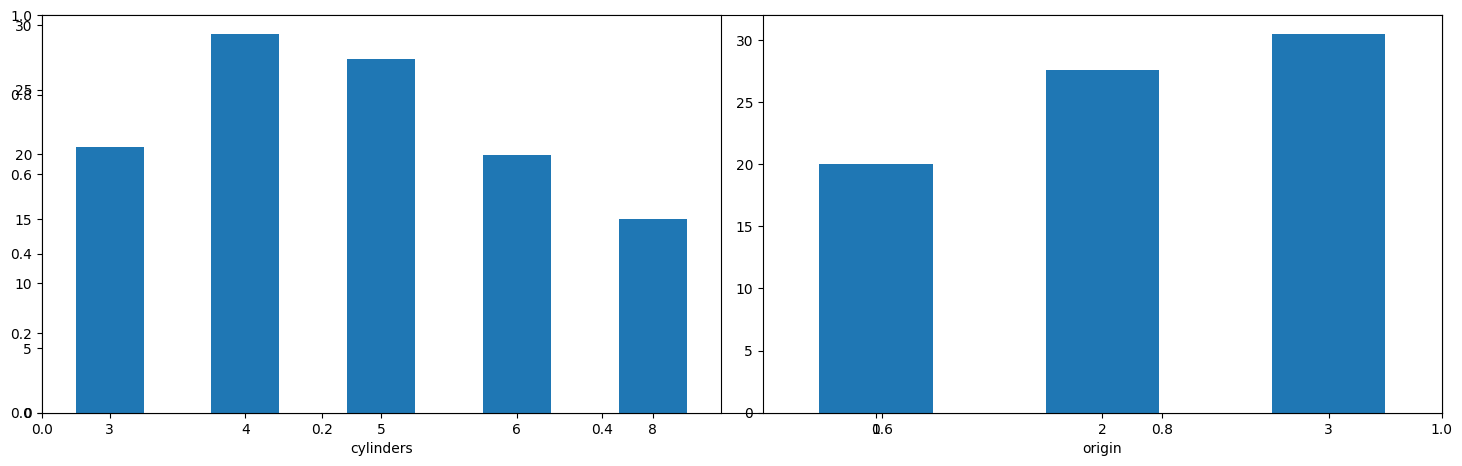

In [10]:
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['number'])

plt.subplots(figsize=(15, 5))
for i, col in enumerate(['cylinders', 'origin']):
    plt.subplot(1, 2, i+1)
    x = numeric_df.groupby(col).mean()['mpg']
    x.plot.bar()
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# This code is modified by Susobhan Akhuli


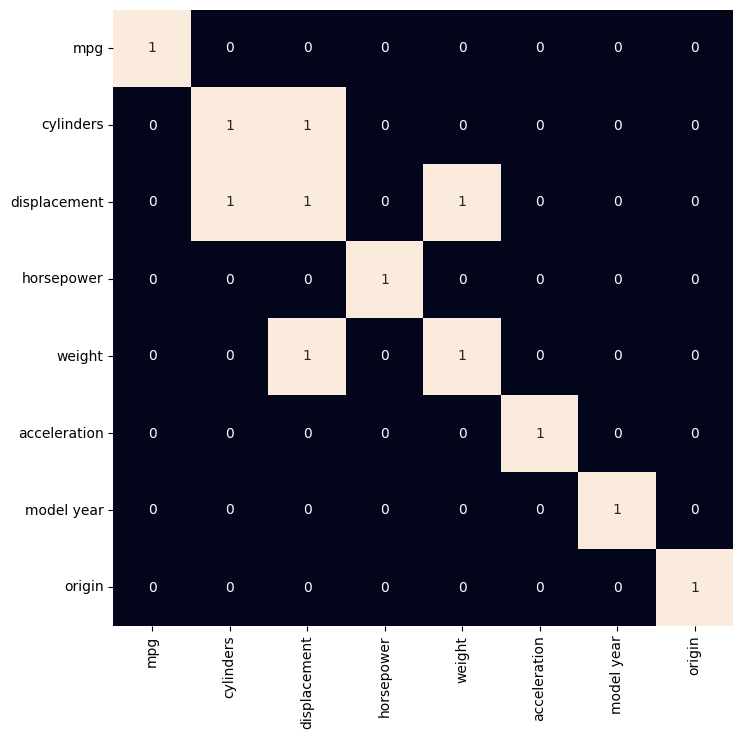

In [11]:
plt.figure(figsize=(8, 8))
sb.heatmap(numeric_df.corr() > 0.9,
		annot=True,
		cbar=False)
plt.show()

# This code is modified by Susobhan Akhuli


In [12]:
df.drop('displacement',
        axis=1,
        inplace=True)


**Data Input Pipeline**

In [13]:
from sklearn.model_selection import train_test_split
features = df.drop(['mpg', 'car name'], axis=1)
target = df['mpg'].values

X_train, X_val, \
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.2,
                                      random_state=22)
X_train.shape, X_val.shape


((313, 6), (79, 6))

In [14]:
AUTO = tf.data.experimental.AUTOTUNE

train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .batch(32)
    .prefetch(AUTO)
)


**Model Architecture**

In [15]:
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[6]),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation='relu')
])


In [16]:
model.compile(
    loss='mae',
    optimizer='adam',
    metrics=['mape']
)


In [17]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,889 (273.00 KB)

 Trainable params: 68,865 (269.00 KB)

 Non-trainable params: 1,024 (4.00 KB)

**Model Trainin**

In [18]:
history = model.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 21.6135 - mape: 93.0091 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18.8026 - mape: 83.4318 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 17.2718 - mape: 78.0675 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15.8904 - mape: 73.3028 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14.6663 - mape: 69.0696 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.4564 - mape: 64.9099 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.4845 - mape: 61.2776 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.6907 - mape: 58.3127 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 9/50
10/1

In [19]:
history_df = pd.DataFrame(history.history)
history_df.head()


,loss,mape,val_loss,val_mape
0,20.804230,90.136612,22.418987,100.0
1,18.542524,82.331024,22.418987,100.0
2,17.020395,76.971169,22.418987,100.0
3,15.699484,72.366837,22.418987,100.0
4,14.475188,68.031624,22.418987,100.0


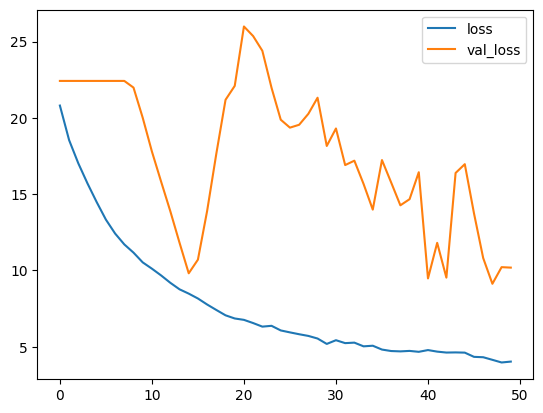

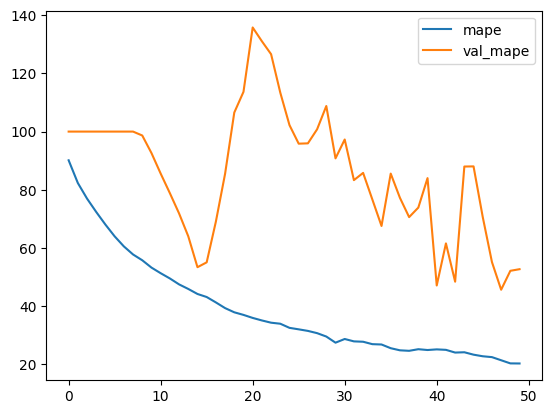

In [20]:
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['mape', 'val_mape']].plot()
plt.show()
